In [2]:
import networkx as nx

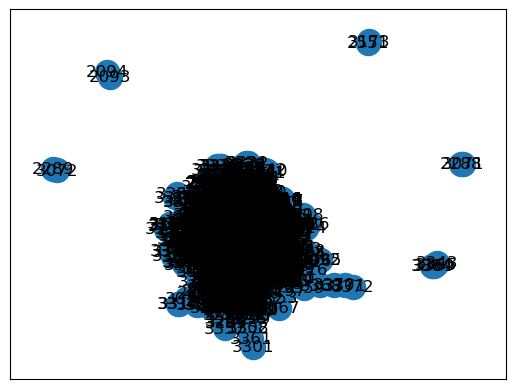

In [4]:
g = nx.read_graphml("airportsAndCoordAndPop.graphml")
nx.draw_networkx(g)